In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm, tqdm_notebook

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DLS Face recognition/celebA_train_500/celebA_anno.txt', header=None, sep=' ')
df.columns = ['Path', 'Class']

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
import torch
from PIL import Image

class CelebADataSet(Dataset):
    def __init__(self, df=None, ptest=80, pval=5):
        """
        Параметр ptest определяет какой процент данных будет отдан для тренировочной выборки
        Параметр pval определяет какой процент данных будет отдан для валидационной выборки
        """
        super().__init__()

        self._path_to_file_name = '/content/drive/MyDrive/DLS Face recognition/celebA_train_500/celebA_imgs'
        self._path_to_annot = '/content/drive/MyDrive/DLS Face recognition/celebA_train_500/celebA_anno.txt'

        # Записываем данные об изображениях в DataFrame
        if df is None:
            self._table = pd.read_csv(self._path_to_annot, header=None, sep=' ')
        else:
            self._table = df
        self._table.columns = ['File_name', 'Class']

        self._len = self._table.shape[0]

        # Получаем индексы для разделения данных на train и test
        # а ля train test split из sklearn
        idx = np.random.choice(self._len, self._len, False)
        p1 = self._len//100 * ptest
        p2 = self._len//100 * (100 - pval)
        self.train_idx, self.test_idx, self.val_idx = np.split(idx, [p1, p2])

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self._table['Class'].values)

    class _Data(Dataset):
        """
        Класс, который будет подаваться в Dataloader
        """
        def __init__(self, upper, idx, train=True):
            super().__init__()
            self._upper = upper
            self.train = train

            self._table = self._upper._table.iloc[idx]

        def __len__(self):
            return len(self._table)

        def load_sample(self, file):
            image = Image.open(file)
            image.load()
            return image

        def __getitem__(self, index):
            path_to_img = os.path.join(self._upper._path_to_file_name,
                                       self._table['File_name'].iloc[index])
            image = self.load_sample(path_to_img)

            make_transforms = {True: transforms.Compose([transforms.Resize(224, antialias=True),
                                                         transforms.RandomRotation((0, 5)),
                                                         transforms.ColorJitter(hue=0.1, saturation=0.1),
                                                         transforms.RandomAdjustSharpness(1, p=0.5),
                                                         transforms.RandomAutocontrast(p=0.5),
                                                         transforms.RandomEqualize(p=0.5),
                                                         transforms.RandomHorizontalFlip(p=0.5),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                               False: transforms.Compose([transforms.Resize(224, antialias=True),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

            image = make_transforms[self.train](image)
            label =  self._upper.label_encoder.transform([self._table['Class'].iloc[index]])[0]

            return image, label

    def get_train(self):
        return self._Data(self, self.train_idx)
    def get_test(self):
        return self._Data(self, self.test_idx, False)
    def get_val(self):
        return self._Data(self, self.val_idx, False)
    def get_train_and_test(self):
        return self.get_train(), self.get_test()

In [ ]:
def fit_epoch(model, train_loader, loss_fn, optimaizer, DEVICE):
    loss_per_epoch = 0
    accuracy_per_epoch = 0
    processed = 0

    num_batch = len(train_loader)

    log_template = "batch: {n:d}/{all:d} train loss: {t_loss:0.4f} train acc {t_acc:0.4f}"

    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # forward and backward
        optimaizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimaizer.step()

        #statistic
        preds = torch.argmax(outputs, 1)
        loss_per_epoch += loss.item() * images.size(0)
        accuracy_per_epoch += torch.sum(preds == labels.data).item()

        processed += images.size(0)
        torch.cuda.empty_cache()

        print(log_template.format(n=i+1, all=num_batch, t_loss=loss_per_epoch/processed, t_acc=accuracy_per_epoch/processed))


    loss_per_epoch = loss_per_epoch / processed
    accuracy_per_epoch = accuracy_per_epoch / processed
    torch.cuda.empty_cache()
    return loss_per_epoch, accuracy_per_epoch

In [ ]:
def test_epoch(model, test_loader, loss_fn, DEVICE):
    loss_per_epoch = 0
    accuracy_per_epoch = 0
    processed = 0

    model.eval()
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = []

        with torch.no_grad():
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            logits.append(outputs)

            #statistic
            processed += images.shape[0]
            loss_per_epoch += loss.item() * images.size(0)

            pred = torch.nn.functional.softmax(torch.cat(logits), dim=-1).to(DEVICE)
            accuracy_per_epoch += torch.sum(torch.argmax(pred, 1) == labels.data).item()
        torch.cuda.empty_cache()

    loss_per_epoch = loss_per_epoch / processed
    accuracy_per_epoch = accuracy_per_epoch / processed
    torch.cuda.empty_cache()
    return loss_per_epoch, accuracy_per_epoch

In [ ]:
def train_model(model, train_loader, test_loader, num_epoch, loss_fn, optimaizer, scheduler, DEVICE):
    history = {'train loss':[], 'test loss': [],
               'train accuracy': [], 'test accuracy': []}

    log_template = "\nEpoch {ep:d} train loss: {t_loss:0.4f} test loss {v_loss:0.4f} train acc {t_acc:0.4f} test acc {v_acc:0.4f}"

    torch.cuda.empty_cache()

    for epoch in range(num_epoch):
        print(f'Epoch {epoch+1}/{num_epoch}')

        torch.cuda.empty_cache()

        train_loss, train_accuracy = fit_epoch(model, train_loader, loss_fn, optimaizer, DEVICE)
        test_loss, test_accuracy = test_epoch(model, test_loader, loss_fn, DEVICE)

        history['train loss'].append(train_loss)
        history['test loss'].append(test_loss)
        history['train accuracy'].append(train_accuracy)
        history['test accuracy'].append(test_accuracy)

        scheduler.step()
        torch.cuda.empty_cache()

        print(log_template.format(ep=epoch, t_loss=train_loss, v_loss=test_loss,
                                  t_acc=train_accuracy, v_acc=test_accuracy))

    torch.cuda.empty_cache()
    return history

In [ ]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

# Загружаю модель пердобученную на ImageNet
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)

In [ ]:
from torch.utils.data import DataLoader

celebA = CelebADataSet(ptest=85)
train, test = celebA.get_train_and_test()

batch_size = 256
num_workers = 2

train_data = DataLoader(train, batch_size=batch_size, num_workers=num_workers)
test_data = DataLoader(test, batch_size=batch_size, num_workers=num_workers)

In [ ]:
# Меняю количество выходов в последннем слое сети на количество классов в обучающей выборке
# Дообучать модель буду по всем весам
N_CLASSES = len(celebA.label_encoder.classes_)

in_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(in_features, N_CLASSES)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)
loss_fn = torch.nn.CrossEntropyLoss()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

In [ ]:
torch.cuda.empty_cache()

num_epoch = 20
history = train_model(model, train_data, test_data, num_epoch, loss_fn, optimizer, scheduler, DEVICE)

Epoch 1/20
batch: 1/40 train loss: 6.2163 train acc 0.0000
batch: 2/40 train loss: 6.2101 train acc 0.0000
batch: 3/40 train loss: 6.2084 train acc 0.0052
batch: 4/40 train loss: 6.2001 train acc 0.0059
batch: 5/40 train loss: 6.1988 train acc 0.0063
batch: 6/40 train loss: 6.1991 train acc 0.0065
batch: 7/40 train loss: 6.1921 train acc 0.0078
batch: 8/40 train loss: 6.1867 train acc 0.0078
batch: 9/40 train loss: 6.1779 train acc 0.0078
batch: 10/40 train loss: 6.1667 train acc 0.0094
batch: 11/40 train loss: 6.1608 train acc 0.0092
batch: 12/40 train loss: 6.1489 train acc 0.0094
batch: 13/40 train loss: 6.1404 train acc 0.0105
batch: 14/40 train loss: 6.1190 train acc 0.0128
batch: 15/40 train loss: 6.0944 train acc 0.0143
batch: 16/40 train loss: 6.0757 train acc 0.0149
batch: 17/40 train loss: 6.0554 train acc 0.0149
batch: 18/40 train loss: 6.0352 train acc 0.0169
batch: 19/40 train loss: 6.0112 train acc 0.0177
batch: 20/40 train loss: 5.9859 train acc 0.0199
batch: 21/40 train

Посмотрим на поведение модели в время обучения и на финальную точность модели после дообучения

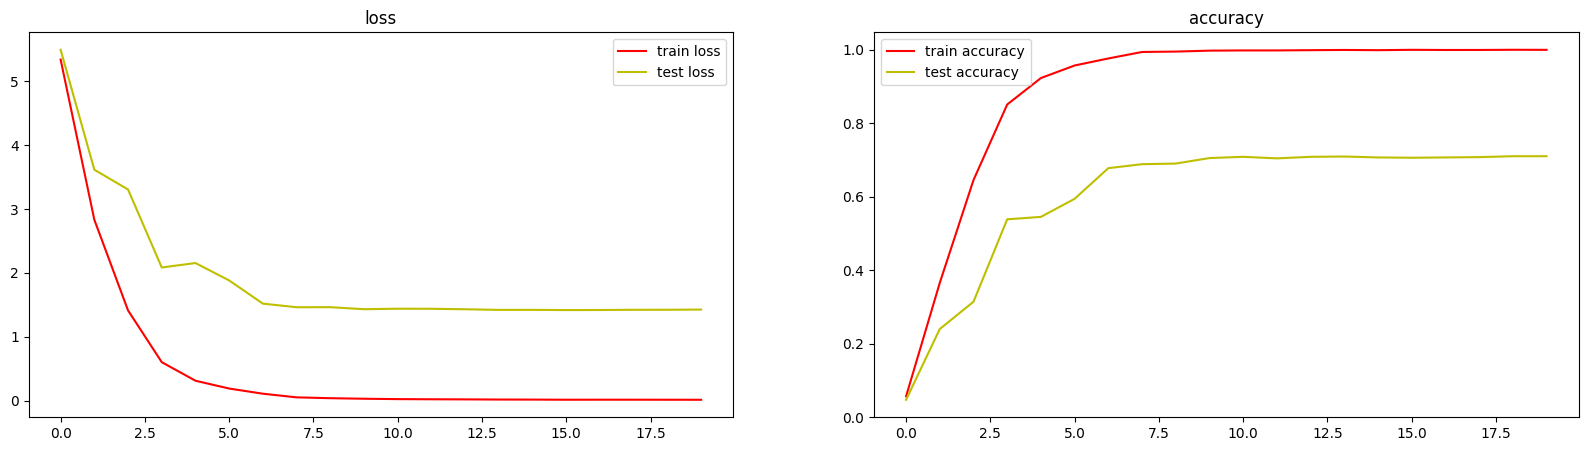

In [ ]:
axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))[1].flatten()

x = [i for i in range(num_epoch)]

y_train_l = history['train loss']
y_test_l = history['test loss']
y_train_acc = history['train accuracy']
y_test_acc = history['test accuracy']

axs[0].plot(x, y_train_l, color='r', label='train loss')
axs[0].plot(x, y_test_l, color='y', label='test loss')
axs[0].title.set_text('loss')
axs[0].legend()

axs[1].plot(x, y_train_acc, color='r', label='train accuracy')
axs[1].plot(x, y_test_acc, color='y', label='test accuracy')
axs[1].title.set_text('accuracy')
axs[1].legend()

In [ ]:
model.eval()
val_data = DataLoader(celebA.get_val(), batch_size=batch_size)

val_loss = 0
val_acc = 0

logits = []
labels_ = []

with torch.no_grad():
    for images, labels in val_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images).cpu()
        logits.append(outputs)
        labels_.extend([*labels])

probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

In [ ]:
prob_ = torch.argmax(torch.Tensor(probs), 1).numpy()
labels_ = torch.Tensor(labels_).numpy()

val_accuracy = np.sum(labels_ == prob_)/len(labels_)
val_accuracy

0.7152209492635024

В итоге, исходя из графика accuracy можно заметить, что модель имеет признаки переобучения, так как на обучающей выборке модель достигла точности в 99.93% на тестовой в 71%, на валидационной выборке модель достигает точности в 71.5%. При использовании весов mobilenet_DLS_FR_weightes_v2.pth модель достигает точности в 73%

In [ ]:
# Сохраняем веса модели
path_to_save_model_state = '/content/drive/MyDrive/DLS Face recognition/models weights/mobilenet_DLS_FR_weightes_v3.pth'
torch.save(model.state_dict(), path_to_save_model_state)

# Identification Rate Metric

Здесь расчет Identification Rate будет производится не при помощи вызова функций, а в виде линейного кода.

In [ ]:
# Загружаем веса дообученной модели и убираем классификационный слой,
# оставляя только предклассификационныцй линейный слой
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_CLASSES = 460

model_rec = mobilenet_v3_large()
in_features = model_rec.classifier[-1].in_features
model_rec.classifier[-1] = torch.nn.Linear(in_features, N_CLASSES)

model_rec.load_state_dict(torch.load('/content/drive/MyDrive/DLS Face recognition/models weights/mobilenet_DLS_FR_weightes_v2.pth',
                                     map_location=torch.device(DEVICE)))

model_rec.classifier = model_rec.classifier[0]
model_rec.classifier

Linear(in_features=960, out_features=1280, bias=True)

In [ ]:
idf_metric_annot_df = pd.read_csv('/content/drive/MyDrive/DLS Face recognition/celebA_ir/celebA_anno_query.csv')
idf_metric_annot_df.columns = ['Path', 'Class']

In [ ]:
# Функция подготавливающая изображение перед подачей его в сеть
def make_transforms(image):
    transformations = transforms.Compose([transforms.Resize(224, antialias=True),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    image = transformations(image)
    image = image[None,:,:,:]
    return image

Посчитаем ембендинги и косинусальное расстояние для query части

In [ ]:
query_embending_df = pd.DataFrame()

# записываем эмбендинги из query части в отдельную таблицу
model_rec.eval()
path_img = '/content/drive/MyDrive/DLS Face recognition/celebA_ir/celebA_query'
for i in range(idf_metric_annot_df.shape[0]):
    path = idf_metric_annot_df['Path'].iloc[i]
    img = make_transforms(
        Image.open(os.path.join(path_img, path)))
    emb = model_rec(img)

    label = idf_metric_annot_df['Class'].iloc[i]
    t = {'Path': path, 'Class': label, 'Embending': emb.tolist()}

    df = pd.DataFrame(t)
    query_embending_df = pd.concat([query_embending_df, df], ignore_index=True)

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

# в similar face и diff face записываю рассчитанное расстояние для одинаковых и разных лиц
cosine_distances_dict = {'similar face': [], 'diff face': []}

for i in range(query_embending_df.shape[0]):
    face1 = np.array(query_embending_df['Embending'].iloc[i]).reshape(1, -1)
    label1 = query_embending_df['Class'].iloc[i]

    for j in range(i + 1, query_embending_df.shape[0]):
        face2 = np.array(query_embending_df['Embending'].iloc[j]).reshape(1, -1)
        label2 = query_embending_df['Class'].iloc[j]

        if label1 == label2:
            cosine_distances_dict['similar face'].append(cosine_distances(face1, face2)[0][0])
        else:
            cosine_distances_dict['diff face'].append(cosine_distances(face1, face2)[0][0])

Посчитаем косинусальное расстояние между query и distractors частями

In [ ]:
cosine_distances_distractors = []

path_to_img = '/content/drive/MyDrive/DLS Face recognition/celebA_ir/celebA_distractors'

for img_name in os.listdir(path_to_img):
    # фиксируем лицо из distractors части
    img = make_transforms(
        Image.open(os.path.join(path_to_img, img_name)))
    face1 = np.array(model_rec(img).tolist())

    for i in range(query_embending_df.shape[0]):
        face2 = np.array(query_embending_df['Embending'].iloc[i]).reshape(1, -1)
        cosine_distances_distractors.append(cosine_distances(face1, face2)[0][0])

Считаем количество positive пар для которых косинусльное растояние меньше некоторого порога при различных FPR значениях

In [ ]:
FPR = [0.5, 0.2, 0.1, 0.05]
rate_list = []

for fpr in FPR:
    N = int((len(cosine_distances_distractors) + len(cosine_distances_dict['diff face'])) * fpr)

    threashold = sorted(cosine_distances_distractors + cosine_distances_dict['diff face'])[N]

    positive_pair = np.array(cosine_distances_dict['similar face'])
    rate_list.append(positive_pair[positive_pair < threashold].size/positive_pair.size)

In [ ]:
for fpr, rate in zip(FPR, rate_list):
    print(f'FPR = {fpr}, rate: {np.around(rate, 4)}')

FPR = 0.5, rate: 0.8039
FPR = 0.2, rate: 0.5454
FPR = 0.1, rate: 0.3995
FPR = 0.05, rate: 0.2947


В итоге можно заметить, что для точного распознования лиц модель MobileNet v3 предобученная на ImageNet обученная при помощи CE не подходит, так как при малых значениях FPR (0.05, 0.1) модель достигает невысоких значений -- 29% и 40%.